In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from routines.models import get_pipe_base
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.kernel_approximation import RBFSampler, Nystroem
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from routines.models import get_balanced_sample_weights, ks_test_d, ks_test_p
from sklearn.metrics import make_scorer, matthews_corrcoef, fbeta_score, classification_report, roc_auc_score, f1_score, log_loss
from time import time
from time import localtime
from routines.transformers import SparseTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import norm as sp_norm
from routines.evals_n_plots import get_cv_res_df, plot_cv_res_df, plot_permut_hist, plot_learning_curve, \
    plot_multi_metric_cv, plot_confusion_matrix, plot_roc_curve, plot_prc_curve
from sklearn.model_selection import permutation_test_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from scipy.stats import ks_2samp
import pickle
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [2]:
random_state: int = 42
sample_test_size: float = 0.20
max_jobs: int = 3
pre_dispatch = 3
outer_cv: int = 5
inner_cv: int = 3

In [3]:
df = pd.read_csv('src/Train_Sample.csv', sep=';', index_col=0)
y = df['Status']
X = df.drop(labels='Status', axis=1, inplace=False)
del df
print('X.shape: {0}\ty.shape: {1}'.format(X.shape, y.shape))

X.shape: (65974, 221)	y.shape: (65974,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=sample_test_size,
                                                    random_state=random_state,
                                                    stratify=y)
print('X_train.shape: {0}\ty_train.shape: {1}\n'
      'X_test.shape: {2}\ty_test.shape: {3}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (52779, 221)	y_train.shape: (52779,)
X_test.shape: (13195, 221)	y_test.shape: (13195,)



In [5]:
corr_threshold = 0.90
var_threshold = (0.98 * (1.00 - 0.98))

pipe_base = get_pipe_base(random_state=random_state, corr_threshold=corr_threshold, var_threshold=var_threshold)
# pipe_base

### Lets fit some Ada Boost Classifier

In [8]:
matthews2 = make_scorer(matthews_corrcoef)
scoring2 = {'AUC': 'roc_auc', 'F1': 'f1', 'MCC': matthews2, '-LogLoss': 'neg_log_loss'}
main_score2 = 'MCC'

In [9]:
pipe_ab = Pipeline(steps=[('pipe_base', pipe_base),
                          ('smote', SMOTE(ratio='auto',
                                          kind='regular',
                                          n_jobs=max_jobs,
                                          random_state=random_state)),
                          ('ada_boost',
                           AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                    max_features='sqrt',
                                                                                    max_depth=2,
                                                                                    min_samples_leaf=0.15,
                                                                                    min_impurity_decrease=0.00, ),
                                              random_state=random_state,
                                              algorithm='SAMME.R',
                                              learning_rate=0.80,
                                              n_estimators=300, )),
                          ],
                   # memory='pipe_cache/'
                   )

In [10]:
# {'gradient_boosting__max_depth': 5.0, 'gradient_boosting__min_impurity_decrease': 0.38000000000000006}
param_grid_ab = {'ada_boost__learning_rate': [0.5, 0.6, 0.7],
                 # 'ada_boost__base_estimator__max_depth': [2, 3, 4],
                 'ada_boost__base_estimator__min_samples_leaf': [0.05, 0.10, 0.15],
                 # 'ada_boost__base_estimator__max_features': ['sqrt', None],
                 # 'ada_boost__n_estimators': [200, 300],
                 }
# param_dist_ab = {'gradient_boosting__max_depth': sp_randint(low=3, high=10),
#                  'gradient_boosting__min_samples_leaf': sp_uniform(loc=0.01, scale=0.20),
#                  # 'gradient_boosting__min_impurity_decrease': [0.00, 0.10, 0.20],
#                  # 'gradient_boosting__learning_rate': sp_uniform(loc=0.05, scale=0.95),
#                  # 'gradient_boosting__n_estimators': sp_randint(low=100, high=400),
#                  # 'gradient_boosting__subsample': sp_uniform(loc=0.30, scale=0.70)
#                  }

In [11]:
gs_ab = GridSearchCV(estimator=pipe_ab,
                     param_grid=param_grid_ab,
                     scoring=scoring2,
                     refit=main_score2,
                     return_train_score=True,
                     cv=inner_cv,
                     n_jobs=max_jobs,
                     pre_dispatch=pre_dispatch, )
# gs_ab = RandomizedSearchCV(estimator=pipe_ab,
#                            param_distributions=param_dist_ab,
#                            n_iter=20,
#                            random_state=random_state,
#                            scoring=scoring2,
#                            refit=main_score2,
#                            return_train_score=True,
#                            cv=inner_cv,
#                            n_jobs=max_jobs,
#                            pre_dispatch=pre_dispatch, )

In [12]:
t0 = time()
gs_ab.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))
gs_gb_best_estim = gs_ab.best_estimator_
print(gs_ab.best_params_)

Fit Time:  2645.420709133148
{'ada_boost__base_estimator__max_depth': 2, 'ada_boost__base_estimator__min_samples_leaf': 0.1, 'ada_boost__learning_rate': 0.7}


In [13]:
gs_ab_best_estim = gs_ab.best_estimator_
gs_ab.best_params_

{'ada_boost__base_estimator__max_depth': 2,
 'ada_boost__base_estimator__min_samples_leaf': 0.1,
 'ada_boost__learning_rate': 0.7}

In [14]:
curr_time = localtime(time())
file_time_part = f'{curr_time.tm_year:04}_{curr_time.tm_mon:02}_{curr_time.tm_mday:02}' \
                 f'_{curr_time.tm_hour:02}_{curr_time.tm_min:02}_{curr_time.tm_sec:02}'
df_tune = pd.DataFrame(gs_ab.cv_results_['params'])
for k in scoring2.keys():
    for tp in ['test', 'train']:
        df_tune['mean_{1}_{0}'.format(k, tp)] = pd.DataFrame(gs_ab.cv_results_['mean_{1}_{0}'.format(k, tp)])
df_tune.sort_values(by='mean_test_MCC', ascending=False).to_excel('tune_hype/ab_' + file_time_part + '.xlsx',
                                                                  index=False)

In [15]:
gs_ab_res_df = get_cv_res_df(gs_ab.cv_results_, gs_ab.best_index_)
gs_ab_res_df

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mean</th>
      <th colspan="2" halign="left">std</th>
    </tr>
    <tr>
      <th></th>
      <th>test</th>
      <th>train</th>
      <th>test</th>
      <th>train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>-LogLoss</th>
      <td>-0.6829</td>
      <td>-0.6827</td>
      <td>0.0001</td>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>AUC</th>
      <td>0.8348</td>
      <td>0.8919</td>
      <td>0.0046</td>
      <td>0.0028</td>
    </tr>
    <tr>
      <th>F1</th>
      <td>0.2543</td>
      <td>0.2973</td>
      <td>0.0083</td>
      <td>0.0141</td>
    </tr>
    <tr>
      <th>MCC</th>
      <td>0.2384</td>
      <td>0.2922</td>
      <td>0.0068</td>
      <td>0.0150</td>
    </tr>
  </tbody>
</table>
</div>

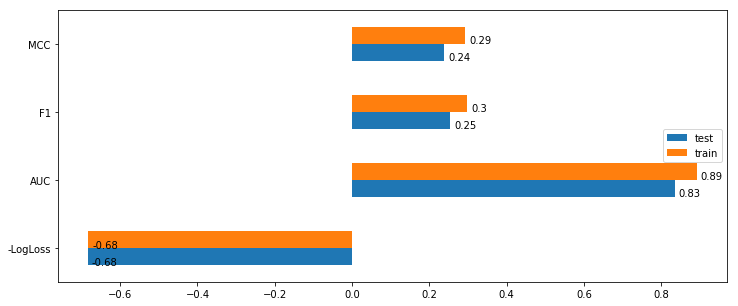

In [16]:
plot_cv_res_df(cv_res_df=gs_ab_res_df, figsize=(12, 5))

In [17]:
t0 = time()
train_sizes_ab, train_scores_ab, test_scores_ab = learning_curve(estimator=gs_ab_best_estim, X=X_test, y=y_test,
                                                                 cv=inner_cv, n_jobs=max_jobs, scoring='roc_auc',
                                                                 train_sizes=np.linspace(0.1, 1.0, 5))
print('Fit Time: ', (time() - t0))

Fit Time:  51.47628474235535


<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

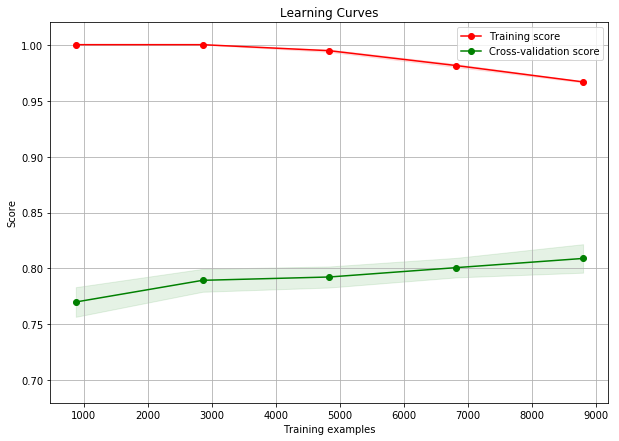

In [18]:
plot_learning_curve(train_sizes=train_sizes_ab, train_scores=train_scores_ab, test_scores=test_scores_ab,
                    title='Learning Curves', ylim=(0.68, 1.02), figsize=(10, 7))

#### REFIT

In [20]:
t0 = time()
gs_ab_best_estim.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Fit Time:  75.10415601730347


In [21]:
t0 = time()
ab_pred_train = gs_ab_best_estim.predict(X_train)
ab_pred_test = gs_ab_best_estim.predict(X_test)
ab_proba_train = gs_ab_best_estim.predict_proba(X_train)
ab_proba_test = gs_ab_best_estim.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  19.264854669570923


In [22]:
print('#TRAIN AB#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, ab_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=ab_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, ab_pred_train),
                ks_2samp(y_train, ab_pred_train)[0],
                ks_2samp(y_train, ab_pred_train)[1],
                log_loss(y_train, ab_proba_train[:, 1]), ))

print('\n#TEST AB#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, ab_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=ab_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, ab_pred_test),
                ks_2samp(y_train, ab_pred_test)[0],
                ks_2samp(y_train, ab_pred_test)[1],
                log_loss(y_test, ab_proba_test[:, 1]), ))

#TRAIN AB#
AUC: 0.8769342126644446
F1: 0.2811441475348137
MCC: 0.27662035140916474
KS: D=0.041455882074309836, p-value=7.072875927244126e-40
Log Loss: 0.6833482553629998

#TEST AB#
AUC: 0.8317548146631497
F1: 0.23971119133574006
MCC: 0.21881186030004515
KS: D=0.03719346475811136, p-value=3.86757282763258e-13
Log Loss: 0.6834736335977708


In [23]:
print(classification_report(y_test, ab_pred_test))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96     12257
          1       0.37      0.18      0.24       938

avg / total       0.90      0.92      0.91     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

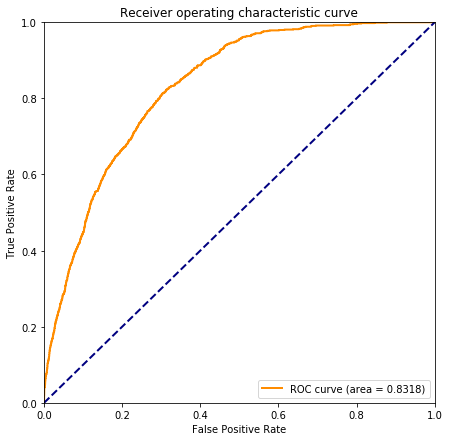

In [26]:
plot_roc_curve(target=y_test, proba=ab_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

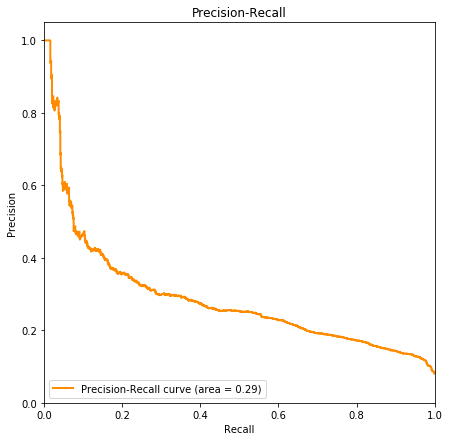

In [27]:
plot_prc_curve(target=y_test, proba=ab_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

###Calibrate AB

In [28]:
pipe_calib_ab = Pipeline(steps=[('pipe_base', pipe_base),
                                ('smote', SMOTE(ratio='auto',
                                                kind='regular',
                                                n_jobs=max_jobs,
                                                random_state=random_state)),
                                ('AB_calibrated', CalibratedClassifierCV(
                                    base_estimator=AdaBoostClassifier(
                                        base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                              max_features='sqrt',
                                                                              max_depth=2,
                                                                              min_samples_leaf=0.10,
                                                                              min_impurity_decrease=0.00, ),
                                        random_state=random_state,
                                        algorithm='SAMME.R',
                                        learning_rate=0.70,
                                        n_estimators=300, ),
                                    cv=5, method='isotonic')),
                                ],
                         # memory='pipe_cache/'
                         )

In [29]:
t0 = time()
pipe_calib_ab.fit(X_train, y_train)
print('Fit Time: ', (time() - t0))

Fit Time:  247.7221977710724


In [30]:
t0 = time()
calib_ab_pred_train = pipe_calib_ab.predict(X_train)
calib_ab_pred_test = pipe_calib_ab.predict(X_test)
calib_ab_proba_train = pipe_calib_ab.predict_proba(X_train)
calib_ab_proba_test = pipe_calib_ab.predict_proba(X_test)
print('Predict Time: ', (time() - t0))

Predict Time:  59.55451536178589


In [31]:
print('#TRAIN AB CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_train, calib_ab_proba_train[:, 1]),
                f1_score(y_true=y_train, y_pred=calib_ab_pred_train,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_train, calib_ab_pred_train),
                ks_2samp(y_train, calib_ab_pred_train)[0],
                ks_2samp(y_train, calib_ab_pred_train)[1],
                log_loss(y_train, calib_ab_proba_train[:, 1]), ))

print('\n#TEST AB CALIBRATED#\nAUC: {}\nF1: {}\nMCC: {}\nKS: D={}, p-value={}\nLog Loss: {}'
      ''.format(roc_auc_score(y_test, calib_ab_proba_test[:, 1]),
                f1_score(y_true=y_test, y_pred=calib_ab_pred_test,
                         pos_label=1, average='binary'),
                matthews_corrcoef(y_test, calib_ab_pred_test),
                ks_2samp(y_train, calib_ab_pred_test)[0],
                ks_2samp(y_train, calib_ab_pred_test)[1],
                log_loss(y_test, calib_ab_proba_test[:, 1]), ))

#TRAIN AB CALIBRATED#
AUC: 0.7723001668022192
F1: 0.08075165058405281
MCC: 0.18083147186043871
KS: D=0.06752685727277896, p-value=4.225619711309312e-105
Log Loss: 0.2230205894407606

#TEST AB CALIBRATED#
AUC: 0.7605758286505444
F1: 0.07106598984771574
MCC: 0.1567229991006674
KS: D=0.06750797783124507, p-value=2.6140674504120607e-42
Log Loss: 0.22742286060373534


In [32]:
print(classification_report(y_test, calib_ab_pred_test))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96     12257
          1       0.74      0.04      0.07       938

avg / total       0.92      0.93      0.90     13195



<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

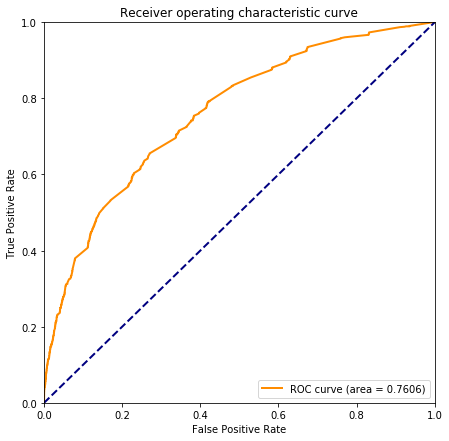

In [33]:
plot_roc_curve(target=y_test, proba=calib_ab_proba_test[:, 1], pos_label=1, figsize=(7, 7))

<module 'matplotlib.pyplot' from 'D:\\moneyveo\\mvt\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

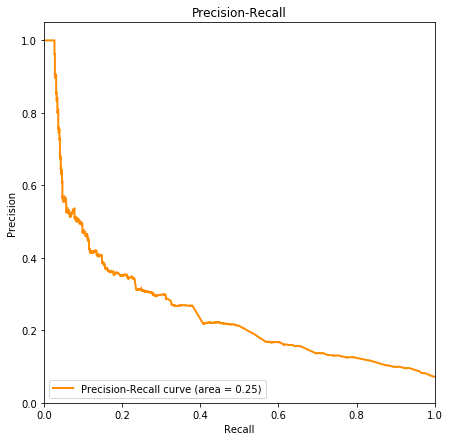

In [34]:
plot_prc_curve(target=y_test, proba=calib_ab_proba_test[:, 1], pos_label=1, average='macro', figsize=(7, 7))

### Plot calibration curves

In [35]:
cc_ab_true_pos, cc_ab_pred_pos = calibration_curve(y_test, ab_proba_test[:, 1], n_bins=10)
cc_calib_ab_true_pos, cc_calib_ab_pred_pos = calibration_curve(y_test, calib_ab_proba_test[:, 1], n_bins=10)

Text(0.5,1,'Calibration curves')

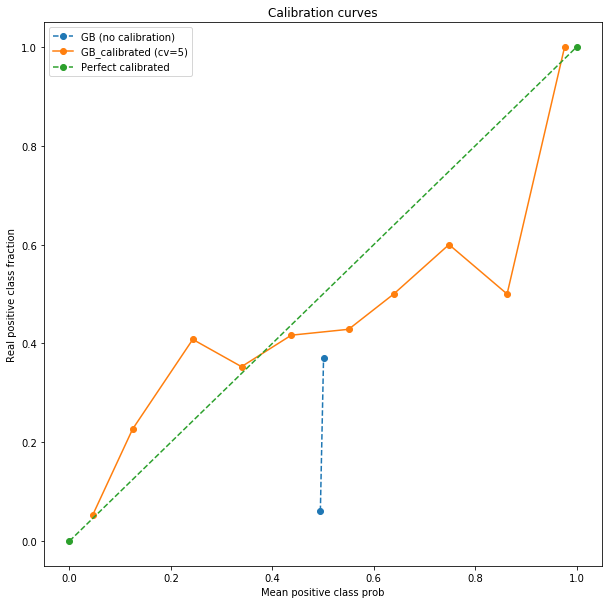

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.plot(cc_ab_pred_pos, cc_ab_true_pos, '--o', label='GB (no calibration)', axes=ax)
plt.plot(cc_calib_ab_pred_pos, cc_calib_ab_true_pos, '-o', label='GB_calibrated (cv=5)', axes=ax)
plt.plot([0, 1], [0, 1], '--o', label='Perfect calibrated')
ax.set_xlabel('Mean positive class prob')
ax.set_ylabel('Real positive class fraction')
ax.legend(loc='best')
ax.set_title('Calibration curves')